In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,activations
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


import tensorflow as tf
from keras.utils import np_utils


Using TensorFlow backend.


In [2]:
# 压缩函数
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in tqdm(df.columns):
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [2]:
#数据读取
train_data = pd.read_csv(r'/mnt/ML/train.csv')
test_data = pd.read_csv(r'/mnt/ML/testA.csv')

In [4]:
#EDA分析
train_data.head().append(train_data.tail())

,id,heartbeat_signals,label
0,0,"0.9912297987616655,0.9435330436439665,0.764677...",0.0
1,1,"0.9714822034884503,0.9289687459588268,0.572932...",0.0
2,2,"1.0,0.9591487564065292,0.7013782792997189,0.23...",2.0
3,3,"0.9757952826275774,0.9340884687738161,0.659636...",0.0
4,4,"0.0,0.055816398940721094,0.26129357194994196,0...",2.0
99995,99995,"1.0,0.677705342021188,0.22239242747868546,0.25...",0.0
99996,99996,"0.9268571578157265,0.9063471198026871,0.636993...",2.0
99997,99997,"0.9258351628306013,0.5873839035878395,0.633226...",3.0
99998,99998,"1.0,0.9947621698382489,0.8297017704865509,0.45...",2.0
99999,99999,"0.9259994004527861,0.916476635326053,0.4042900...",0.0


In [5]:
train_data.shape

(100000, 3)

In [6]:
test_data.head().append(test_data.tail())

,id,heartbeat_signals
0,100000,"0.9915713654170097,1.0,0.6318163407681274,0.13..."
1,100001,"0.6075533139615096,0.5417083883163654,0.340694..."
2,100002,"0.9752726292239277,0.6710965234906665,0.686758..."
3,100003,"0.9956348033996116,0.9170249621481004,0.521096..."
4,100004,"1.0,0.8879490481178918,0.745564725322326,0.531..."
19995,119995,"1.0,0.8330283177934747,0.6340472606311671,0.63..."
19996,119996,"1.0,0.8259705825857048,0.4521053488322387,0.08..."
19997,119997,"0.951744840752379,0.9162611283848351,0.6675251..."
19998,119998,"0.9276692903808186,0.6771898159607004,0.242906..."
19999,119999,"0.6653212231837624,0.527064114047737,0.5166625..."


In [7]:
test_data.shape

(20000, 2)

In [8]:
train_data.describe()

,id,label
count,100000.000000,100000.000000
mean,49999.500000,0.856960
std,28867.657797,1.217084
min,0.000000,0.000000
25%,24999.750000,0.000000
50%,49999.500000,0.000000
75%,74999.250000,2.000000
max,99999.000000,3.000000


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
id                   100000 non-null int64
heartbeat_signals    100000 non-null object
label                100000 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.3+ MB


In [10]:
test_data.describe()

,id
count,20000.000000
mean,109999.500000
std,5773.647028
min,100000.000000
25%,104999.750000
50%,109999.500000
75%,114999.250000
max,119999.000000


In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
id                   20000 non-null int64
heartbeat_signals    20000 non-null object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [12]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id                   0
heartbeat_signals    0
label                0
dtype: int64
id                   0
heartbeat_signals    0
dtype: int64


In [13]:
train_data['label'].value_counts()

0.0    64327
3.0    17912
2.0    14199
1.0     3562
Name: label, dtype: int64

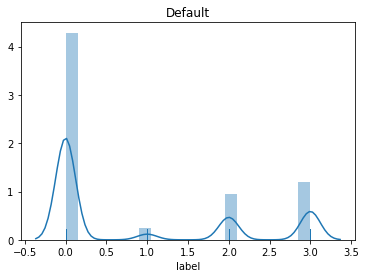

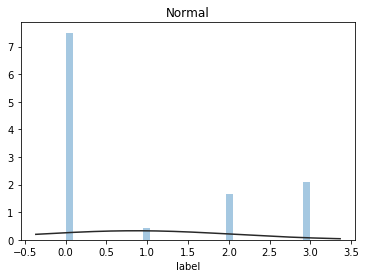

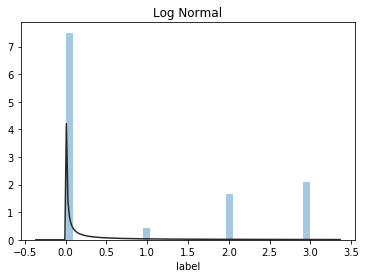

In [16]:
## 1) 总体分布概况（无界约翰逊分布等）
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

y = train_data['label']
plt.figure(1); plt.title('Default')
sns.distplot(y, rug=True, bins=20)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

Skewness: 0.871005
Kurtosis: -1.009573


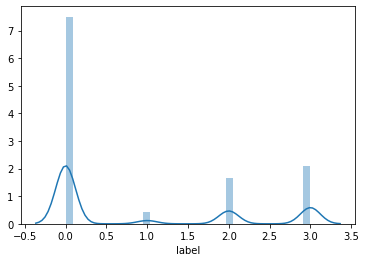

In [17]:

# 2）查看skewness and kurtosis
sns.distplot(train_data['label']);
print("Skewness: %f" % train_data['label'].skew())
print("Kurtosis: %f" % train_data['label'].kurt())

In [18]:
train_data.skew(), train_data.kurt()

(id       0.000000
 label    0.871005
 dtype: float64,
 id      -1.200000
 label   -1.009573
 dtype: float64)

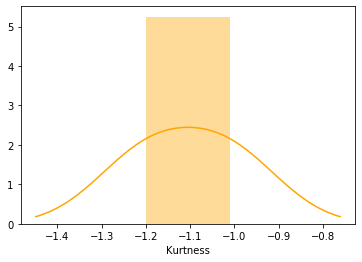

In [19]:
sns.distplot(train_data.kurt(),color='orange',axlabel ='Kurtness')

In [21]:
# 回收垃圾
import gc

gc.collect()

113957

In [3]:
#模型搭建
#数据预处理
train_get_feature = [k.split(',') for k in train_data.heartbeat_signals]
test_get_feature = [k.split(',') for k in test_data.heartbeat_signals]

train_feature = pd.DataFrame(train_get_feature)
train_feature = train_feature.astype(float)

test_feature = pd.DataFrame(test_get_feature)
test_feature = test_feature.astype(float)


In [4]:
X_train, X_validation, Y_train, Y_validation = train_test_split(train_feature, train_data.label, test_size=0.2,random_state=42)

train_X = np.array(X_train)
train_Y = np.array(Y_train)
X_validation = np.array(X_validation)
Y_validation = np.array(Y_validation)


train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 1)

In [28]:
print(len(train_X))
print(len(X_validation))

80000
20000


In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=(8,), padding='same',
                           activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape=(train_X.shape[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=(4,), strides=2, padding='same'),

    tf.keras.layers.Conv1D(filters=64, kernel_size=(8,), padding='same',
                           activation=tf.keras.layers.LeakyReLU(alpha=0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=(4,), strides=2, padding='same'),
    
    tf.keras.layers.Conv1D(filters=128, kernel_size=(6,), padding='same',
                           activation=tf.keras.layers.LeakyReLU(alpha=0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=(3,), strides=2, padding='same'),

    tf.keras.layers.Conv1D(filters=128, kernel_size=(4,), padding='same',
                           activation=tf.keras.layers.LeakyReLU(alpha=0.001)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=(3,), strides=1, padding='same'),
                           
    tf.keras.layers.Conv1D(filters=256, kernel_size=(2,), padding='same',
                           activation=tf.keras.layers.LeakyReLU(alpha=0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=(3,), strides=1, padding='same'),
    
    tf.keras.layers.Conv1D(filters=512, kernel_size=(2,), padding='same',
                           activation=tf.keras.layers.LeakyReLU(alpha=0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=(2,), strides=1, padding='same'),
    
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation=tf.keras.layers.LeakyReLU(alpha=0.001)),
    tf.keras.layers.Dense(units=4, activation='softmax')
])


model.summary()
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=1e-6, nesterov=False)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

num_epochs = 64
cnn=model.fit(train_X,
          train_Y,
          batch_size=64,
          epochs=num_epochs,
          validation_data=(X_validation,Y_validation),
          verbose=2)


def abs_sum(y_tru, y_pre):
    y_tru = pd.get_dummies(data=y_tru)
    y_pre = np.array(y_pre)
    y_tru = np.array(y_tru)
    loss = sum(sum(abs(y_pre - y_tru)))
    return loss


pre = model.predict(X_validation)
print(abs_sum(Y_validation, pre))



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 205, 64)           576       
_________________________________________________________________
batch_normalization (BatchNo (None, 205, 64)           256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 103, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 103, 64)           32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 103, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 52, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 52, 128)           4

In [30]:
pre2=pre.copy()
for i in range(len(pre2)):
    for j in range(len(pre2[0])):
        pre2[i][j]=int(pre2[i][j]+0.5)
#取整后结果
print(abs_sum(Y_validation, pre2))

198.0


In [8]:
#第二个模型：ResNet引入残差
from tensorflow.keras import layers,activations
class Residual(tf.keras.Model):
    def __init__(self, num_channels,kernel_size, use_1x1conv=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = layers.Conv1D(num_channels,
                                   padding='same',
                                   kernel_size=kernel_size,
                                   strides=strides)
        self.conv2 = layers.Conv1D(num_channels, kernel_size=kernel_size,padding='same')
        if use_1x1conv:
            self.conv3 = layers.Conv1D(num_channels,
                                       kernel_size=1,
                                       strides=strides)
        else:
            self.conv3 = None
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()

    def call(self, X):
        Y = activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return activations.relu(Y + X)


class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self,num_channels,kernel_size, num_residuals, first_block=False,**kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.listLayers=[]
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.listLayers.append(Residual(num_channels,kernel_size, use_1x1conv=True, strides=2))
            else:
                self.listLayers.append(Residual(num_channels,kernel_size))      

    def call(self, X):
        for layer in self.listLayers.layers:
            X = layer(X)
        return X


class ResNet(tf.keras.Model):
    def __init__(self,num_blocks,**kwargs):
        super(ResNet, self).__init__(**kwargs)
        self.conv=layers.Conv1D(64, kernel_size=5, padding='same')
        self.bn=layers.BatchNormalization()
        self.relu=layers.LeakyReLU(alpha=0.001)
        self.mp=layers.MaxPool1D(pool_size=5, strides=2, padding='same')
        self.resnet_block1=ResnetBlock(64,8,num_blocks[0], first_block=True)
        self.resnet_block2=ResnetBlock(128,6,num_blocks[1])
        self.resnet_block3=ResnetBlock(256,4,num_blocks[2])
        self.resnet_block4=ResnetBlock(512,2,num_blocks[3])
        self.gap=layers.GlobalAvgPool1D()
        self.fc=layers.Dense(units=4,activation=activations.softmax)

    def call(self, x):
        x=self.conv(x)
        x=self.bn(x)
        x=self.relu(x)
        x=self.mp(x)
        x=self.resnet_block1(x)
        x=self.resnet_block2(x)
        x=self.resnet_block3(x)
        x=self.resnet_block4(x)
        x=self.gap(x)
        x=self.fc(x)
        return x
class ResBlock(tf.keras.Model):
    def __init__(self,num_blocks,**kwargs):
        super(ResNet, self).__init__(**kwargs)
        self.conv=layers.Conv1D(128, kernel_size=8, padding='same')
        self.bn=layers.BatchNormalization()
        self.relu=layers.LeakyReLU(alpha=0.001)
        self.mp=layers.MaxPool1D(pool_size=5, strides=2, padding='same')
        self.resnet_block1=ResnetBlock(128,8,num_blocks[0], first_block=True)
        self.gap=layers.GlobalAvgPool1D()
        self.fc=layers.Dense(units=4,activation=activations.softmax)

    def call(self, x):
        x=self.conv(x)
        x=self.bn(x)
        x=self.relu(x)
        x=self.mp(x)
        x=self.resnet_block1(x)
        x=self.gap(x)
        x=self.fc(x)
        return x

def build_resnet(keyword = 'resnet34'):
    if keyword == 'resnet34':
        return ResNet([3,4,6,3])
    elif keyword == 'resnet18':
        return ResNet([2,2,2,2])
def build_resblock():
    return ResBlock([1])



In [ ]:

def train_resnet(batch_size, epoch):
    # build model
    net =build_resnet('resnet18')  # resnet18 resnet34
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=1e-6, nesterov=False)    
    net.compile(optimizer=optimizer ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    net.fit(train_X,
            train_Y,
            epochs=epoch,
            verbose=2,
            validation_data=(X_validation,Y_validation),
            batch_size=batch_size, 
            shuffle=True)
    return net

def train_resblock(batch_size, epoch):
    # build model
    net =build_resblock()
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=1e-6, nesterov=False)    
    net.compile(optimizer=optimizer ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    net.fit(train_X,
            train_Y,
            epochs=epoch,
            verbose=2,
            validation_data=(X_validation,Y_validation),
            batch_size=batch_size, 
            shuffle=True)
    return net
resnet=train_resnet(64,60)
print(resnet.summary())
resblock=train_resblock(64,100)
print(resblock.summary())


#output 直接预测
def abs_sum(y_tru, y_pre):
    y_tru = pd.get_dummies(data=y_tru)
    y_pre = np.array(y_pre)
    y_tru = np.array(y_tru)
    loss = sum(sum(abs(y_pre - y_tru)))
    return loss


pre3 = resnet.predict(X_validation)
pre_block=resblock.predict(X_validation)
pre4=pre3.copy()
pre_block_cut=pre_block.copy()
for i in range(len(pre4)):
    for j in range(len(pre4[0])):
        pre4[i][j]=int(pre4[i][j]+0.5)
for i in range(len(pre_block)):
    for j in range(len(pre_block[0])):
        pre_block_cut[i][j]=int(pre_block_cut[i][j]+0.5)
#取整
print(abs_sum(Y_validation, pre3))
print(abs_sum(Y_validation, pre4))
print(abs_sum(Y_validation, pre_block))
print(abs_sum(Y_validation, pre_block_cut))

Train on 80000 samples, validate on 20000 samples
Epoch 1/60
80000/80000 - 93s - loss: 0.1306 - accuracy: 0.9601 - val_loss: 0.0969 - val_accuracy: 0.9690
Epoch 2/60
80000/80000 - 82s - loss: 0.0553 - accuracy: 0.9827 - val_loss: 0.1396 - val_accuracy: 0.9531
Epoch 3/60


In [ ]:
w=[2/5,2/5,1/5]
#加权融合
merge_pre=pre.copy()
for i in range(len(merge_pre)):
    for j in range(len(merge_pre[0])):
        merge_pre[i][j]=int(pre[i][j]*w[0]+pre3[i][j]*w[1]+pre_block+0.5)
print(abs_sum(Y_validation, merge_pre))

In [ ]:
#预测
w=[1/3,1/3,1/3]
test_feature = pd.DataFrame(test_get_feature)
test_feature = test_feature.astype(float)
test_X = np.array(test_feature)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)
pre_a1 = model.predict(test_X)
pre_a2=resnet.predict(text_X)
pre_a=pre_a1.copy()
for i in range(len(pre_a)):
    for j in range(len(pre_a1[0])):
        pre_a[i][j]=int(pre_a1[i][j]*w[0]+pre_a2[i][j]*w[1]+0.5)
data_test_price = pd.DataFrame(pre_a,columns = ['label_0','label_1','label_2','label_3'])
results = pd.concat([test_data['id'],data_test_price],axis = 1)
submit_file_z_score = r'/mnt/ML/cnn_A_final.csv'
results.to_csv(submit_file_z_score,encoding='utf8',index=0)


#l另一个测试集
test_data1 = pd.read_csv(r'/mnt/ML/testB.csv')

test_data1.heartbeat_signals

test_get_feature1 = [k.split(',') for k in test_data1.heartbeat_signals]

test_feature1 = pd.DataFrame(test_get_feature1)
test_feature1 = test_feature1.astype(float)
test_X1 = np.array(test_feature1)
test_X1 = test_X1.reshape(test_X1.shape[0], test_X1.shape[1], 1)
pre_b1 = model.predict(test_X1)

pre_b1 = model.predict(test_X1)
pre_b2=resnet.predict(text_X1)
pre_b=pre_b1.copy()
for i in range(len(pre_b)):
    for j in range(len(pre_b1[0])):
        pre_b[i][j]=int(pre_b1[i][j]*w[0]+pre_b2[i][j]*w[1]+0.5)
data_test_price1 = pd.DataFrame(pre_b,columns = ['label_0','label_1','label_2','label_3'])
results1 = pd.concat([test_data1['id'],data_test_price1],axis = 1)
submit_file_z_score1 = r'/mnt/ML/cnn_B_final.csv'
results1.to_csv(submit_file_z_score1,encoding='utf8',index=0)